In [1]:
%matplotlib inline
import tensorflow as tf

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(7)  
import os
import matplotlib.pyplot as plt

tf.__version__

'1.4.0'

In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
def normalize(data, coefficients):
    data = np.array(data, dtype=np.float32)
    for index, c in enumerate(coefficients): 
        data[:,index] /= c
    return data

In [4]:
def load_data(filename="data.csv", delimiter=";", skiprows=1, class1='NORMAL', class2='TRISOMY 21', force=False, normalization=True):
    filepath = os.path.join('data', filename)
    npy_filepath_x = os.path.join('data', filename + '_x.npy')
    npy_filepath_y = os.path.join('data', filename + '_y.npy')
    npy_filepath_coefficients = os.path.join('data', filename + '_coefficients.npy')
    x = []
    y = []
    coefficients = []
    if force or not os.path.isfile(npy_filepath_x) or not os.path.isfile(npy_filepath_y):
        raw_data = np.loadtxt(filepath, delimiter=delimiter, skiprows=skiprows, dtype=str)
        for line in raw_data:
            app = [n for n in line]
            app = [float(n) for n in app[2:14]]
            x.append(np.asarray(app))
            y.append(0 if line[1] == class1 else 1)
        x = np.array(x)
        y = np.array(y)
        if normalization:
            coefficients = x.max(axis=0)
            x = x / x.max(axis=0)
        np.save(npy_filepath_x, x);
        np.save(npy_filepath_y, y);
        np.save(npy_filepath_coefficients, coefficients);
    else:
        x = np.load(npy_filepath_x)
        y = np.load(npy_filepath_y)
        coefficients = np.load(npy_filepath_coefficients)

    return coefficients, x, y;

In [5]:
(coefficients, x, y) = load_data(force=True);

In [6]:
batch_size = 512
nb_classes = 2
nb_epoch = 3
# dense layer size
dense_layer_size1 = 100
# checkpoint path
checkpoints_filepath = "checkpoints/checkpoints.hdf5"
class_names = ['NORMAL', 'TRISOMY 21']

In [7]:
size = y.size
training_size = int((size/100)*80)

X_train = x[0:training_size]
X_test = x[training_size:size]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

Y_train = y[0:training_size]
Y_test = y[training_size:size]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

X_train shape: (32, 12)
32 train samples
8 test samples


In [8]:
def initialize_network_single_column(model, nb_classes, dense_layer_size1):
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons', 
                    input_shape=(12, )))
    model.add(Activation('relu', name='activation_1_' + 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['acc'])

def try_load_checkpoints(model, checkpoints_filepath, warn=True):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')
        
model = Sequential()
initialize_network_single_column(model, nb_classes, dense_layer_size1)
try_load_checkpoints(model, checkpoints_filepath)

In [9]:
# checkpoint
checkpoint = ModelCheckpoint(checkpoints_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# fits the model on clear training set, for nb_epoch-700 epochs
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test), 
                    callbacks=callbacks_list)

# ensuring best val_precision reached during training
model.load_weights(checkpoints_filepath)

Epoch 00001: acc improved from -inf to 0.34375, saving model to checkpoints/checkpoints.hdf5
Epoch 00002: acc improved from 0.34375 to 0.37500, saving model to checkpoints/checkpoints.hdf5
Epoch 00003: acc improved from 0.37500 to 0.40625, saving model to checkpoints/checkpoints.hdf5


In [10]:
print('evaluating new model')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

evaluating new model
Test score: 0.683734416962
Test accuracy: 0.625


In [11]:
def plot_history(history, metric='acc', loc='lower right'): 
    # list all data in history
    # print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    if metric == 'acc': 
        metric = 'accuracy'
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc=loc)
    plt.show()

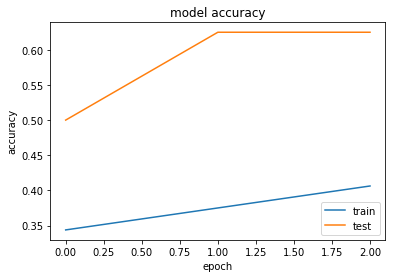

In [12]:
plot_history(history)

In [13]:
def predictions(data, coefficients):
    pred = model.predict_classes(normalize(data, coefficients))
    pred_class = [class_names[n] for n in pred]
    return pred_class

In [14]:
# test with random data to predict
predictions([[1,2,3,4,5,6,7,8,9,0,11,12], [0,12,2,4,5,5,6,7,1,3,0,0]], coefficients)

['TRISOMY 21', 'NORMAL']